# Lab2 EEGNet

In [1]:
import os
import torch
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import read_bci_data

1.4.0
cuda


## TensorDataset & DataLoader
batch_size=256  

In [2]:
X_train,y_train,X_test,y_test=read_bci_data()
dataset=TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
loader_train=DataLoader(dataset,batch_size=256,shuffle=True,num_workers=4)
dataset=TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
loader_test=DataLoader(dataset,batch_size=256,shuffle=False,num_workers=4)
print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
(tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]]],
       dtype=torch.float64), tensor([1., 0., 1.], dtype=torch.float64))


sample_id:73


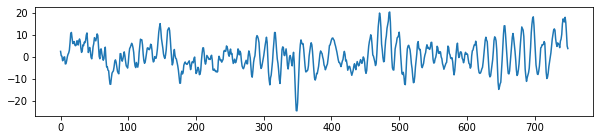

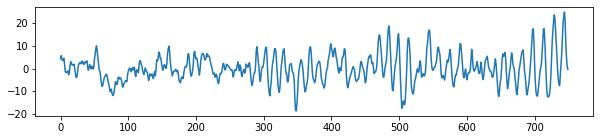

In [3]:
randi=int(np.random.randint(0,X_train.shape[0],1))
print(f'sample_id:{randi}')
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,0])
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,1])

## Model
![eegnet](eegnet.png)  

In [4]:
class EEGNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(EEGNet,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Linear(736,2)
    def forward(self,X):
        out=self.firstconv(X)
        out=self.depthwiseConv(out)
        out=self.seperableConv(out)
        out=out.view(out.shape[0],-1)
        out=self.classify(out)
        return out

## Train & Evaluate
__loss function:__ cross entropy  
__optimizer:__ adam  
__learning rate:__ 0.001  
__weight decay:__ 0.01  
__epoch:__ 300    
__activation fuction:__ ReLU,LeakyReLU,ELU  

In [5]:
lr=0.001
epochs=300

In [6]:
def train_with_different_activation(loader_train,loader_test,activations,device):
    """
    Args:
        loader_train: training dataloader
        loader_test: testing dataloader
        activations: {ReLU,LeakyReLU,ELU} pytorch layer
        
        device: pytorch device gpu,cpu
    Return:
        dataframe: with column 'epoch','ReLU_train','ReLU_test','LeakyReLU_train'...
        best_model_wts: models' weight with the best evaluated accuracy
    """
    Loss=nn.CrossEntropyLoss()
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts={'ReLU':None,'LeakyReLU':None,'ELU':None}
    best_evaluated_acc={'ReLU':0,'LeakyReLU':0,'ELU':0}
    for name,activation in activations.items():
        """
        train model with an specific activation function
        """
        model=EEGNet(activation)
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=0.01)
        acc_train=list()
        acc_test=list()
        for epoch in range(1,epochs+1):
            """
            train
            """
            model.train()
            total_loss=0
            correct=0
            for idx,(data,target) in enumerate(loader_train):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long) #target type has to be 'long'
                predict=model(data)
                loss=Loss(predict,target)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(target).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            correct=100.*correct/len(loader_train.dataset)
            if epoch%10==0:
                print(f'epcoh{epoch:>3d}  loss:{total_loss:.4f}  acc:{correct:.1f}%')
            acc_train.append(correct)
            """
            test
            """
            model.eval()
            correct=evaluate(model,loader_test,device)
            acc_test.append(correct)
            # update best_model_wts
            if correct>best_evaluated_acc[name]:
                best_evaluated_acc[name]=correct
                best_model_wts[name]=copy.deepcopy(model.state_dict())
        df[name+'_train']=acc_train
        df[name+'_test']=acc_test

    return df,best_model_wts

In [7]:
def evaluate(model,loader_test,device):
    model.eval()
    correct=0
    for idx,(data,target) in enumerate(loader_test):
        data=data.to(device,dtype=torch.float)
        target=target.to(device,dtype=torch.long)
        predict=model(data)
        correct+=predict.max(dim=1)[1].eq(target).sum().item()
    
    correct=100.*correct/len(loader_test.dataset)
    return correct

## Plot

In [8]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    return fig

## Run model

In [9]:
activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
df,best_model_wts=train_with_different_activation(loader_train,loader_test,activations,device)
for name,model_wts in best_model_wts.items():
    torch.save(model_wts,os.path.join('eeg models',name+'.pt'))

epcoh 10  loss:0.0022  acc:75.8%
epcoh 20  loss:0.0020  acc:80.7%
epcoh 30  loss:0.0017  acc:83.2%
epcoh 40  loss:0.0014  acc:87.7%
epcoh 50  loss:0.0012  acc:88.6%
epcoh 60  loss:0.0011  acc:91.0%
epcoh 70  loss:0.0009  acc:92.1%
epcoh 80  loss:0.0010  acc:92.0%
epcoh 90  loss:0.0009  acc:92.7%
epcoh100  loss:0.0008  acc:94.4%
epcoh110  loss:0.0008  acc:93.5%
epcoh120  loss:0.0007  acc:94.8%
epcoh130  loss:0.0006  acc:95.4%
epcoh140  loss:0.0006  acc:96.3%
epcoh150  loss:0.0006  acc:95.5%
epcoh160  loss:0.0005  acc:97.1%
epcoh170  loss:0.0006  acc:96.8%
epcoh180  loss:0.0006  acc:95.2%
epcoh190  loss:0.0005  acc:96.5%
epcoh200  loss:0.0006  acc:96.8%
epcoh210  loss:0.0005  acc:96.1%
epcoh220  loss:0.0005  acc:96.9%
epcoh230  loss:0.0005  acc:96.9%
epcoh240  loss:0.0005  acc:97.2%
epcoh250  loss:0.0006  acc:96.7%
epcoh260  loss:0.0005  acc:97.0%
epcoh270  loss:0.0005  acc:96.4%
epcoh280  loss:0.0004  acc:97.7%
epcoh290  loss:0.0005  acc:97.0%
epcoh300  loss:0.0005  acc:97.0%
epcoh 10  

In [10]:
df[-10:]

,epoch,ReLU_train,ReLU_test,LeakyReLU_train,LeakyReLU_test,ELU_train,ELU_test
290,291,96.851852,87.037037,97.500000,84.722222,91.111111,82.962963
291,292,97.222222,85.555556,96.944444,86.203704,91.574074,83.425926
292,293,96.851852,86.388889,97.592593,86.574074,91.388889,83.703704
293,294,96.666667,85.370370,97.685185,86.759259,90.925926,83.333333
294,295,96.944444,86.574074,97.314815,86.574074,91.666667,83.425926
295,296,96.944444,87.592593,97.870370,85.740741,92.037037,83.148148
296,297,96.944444,87.685185,96.851852,85.000000,91.574074,84.166667
297,298,96.666667,87.407407,97.222222,85.740741,91.296296,83.981481
298,299,96.944444,86.203704,97.314815,87.500000,90.925926,83.333333
299,300,97.037037,86.296296,98.611111,85.833333,90.462963,83.240741


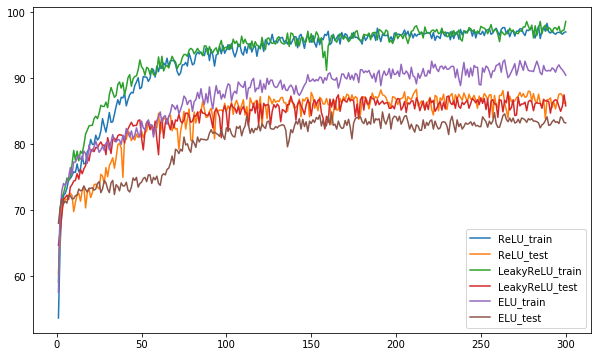

In [11]:
figure=plot(df)
figure.savefig('eeg result.png')

In [12]:
for column in df.columns[1:]:
    print(f'{column} max acc: {df[column].max()}')

ReLU_train max acc: 98.33333333333333
ReLU_test max acc: 88.33333333333333
LeakyReLU_train max acc: 98.61111111111111
LeakyReLU_test max acc: 87.96296296296296
ELU_train max acc: 92.77777777777777
ELU_test max acc: 85.37037037037037
